In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import er
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp
from scipy import stats
from sklearn import metrics
from ortools.sat.python import cp_model
import copy

# Configuration
data_folder = '/app/data'

# Load data
data = er.load_data(data_folder)
data.sort_values(by='Triage', inplace=True);
data.reset_index(inplace=True);
data.drop(columns='index', inplace=True);

# Discard abandons
fdata = data[~data['TkCharge'].isnull()]

# Fixed problem data
capacities = {'visit': 3, 'ultrasound': 2, 'RX': 2}

# Waiting Time

## Waiting Time

**So far, we have assumed the makespan as our cost metric**

In an ER center, we are likely more interested in the _waiting time_

* This can be defined simply as the sum of the start times of the initial tasks

$$
w = \sum_{i=1}^n s^{\mathit{first}}_i
$$

* Where $s^{\mathit{first}}_i$ is the start time of the first task of patient $i$

**Patients are color-coded: it makes sense to _track different waiting times_**

* Ideally, we should also accord priority to the more severe cases
* ...But let's do one step at a time

## Waiting Time

**We can _build waiting time variables_, similar to what we did for the makespan**

```python
def add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh):
    codes = ['red', 'yellow', 'green', 'white']
    fbc = {c: [] for c in codes}
    for idx in levels.keys():
        fbc[codes_by_idx[idx]].append(tasks[idx, 0, 0])

    obj_by_code = {}
    for code in codes:
        obj_by_code[code] = mdl.NewIntVar(0, len(codes_by_idx)*eoh, f'wt_{code}')
        if len(fbc[code]) > 0:
            mdl.Add(obj_by_code[code] == sum(t.start for t in fbc[code]))
    obj_by_code['all'] = mdl.NewIntVar(0, len(codes_by_idx) * eoh, 'wt_global')
    mdl.Add(obj_by_code['all'] ==  sum(obj_by_code[c] for c in codes))
    return obj_by_code
```

## Waiting Time

**First, we _collect the first task_ for each patient, by code:**

```python
def add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh):
    ...
    fbc = {c: [] for c in codes}
    for idx in levels.keys():
        fbc[codes_by_idx[idx]].append(tasks[idx, 0, 0])
    ...
```

**Then, we _build and constrain_ the waiting time variables**

```python
def add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh):
    ...
    obj_by_code = {}
    for code in codes:
        obj_by_code[code] = mdl.NewIntVar(0, len(codes_by_idx)*eoh, f'wt_{code}')
        if len(fbc[code]) > 0:
            mdl.Add(obj_by_code[code] == sum(t.start for t in fbc[code]))
    obj_by_code['all'] = mdl.NewIntVar(0, len(codes_by_idx) * eoh, f'wt_globai')
    mdl.Add(obj_by_code['all'] ==  sum(obj_by_code[c] for c in codes))
    ...
```

## Waiting Time

**We can formulate an _updated problem model_:**

In [2]:
npatients = 5
mdl = cp_model.CpModel()
levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)
er.add_cumulatives(mdl, tasks, capacities)
er.add_all_no_overlap(mdl, levels, tasks)
obj_by_code = er.add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh)
mdl.Minimize(obj_by_code['all'])
slv = cp_model.CpSolver()
slv.parameters.max_time_in_seconds = 10
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.01, objective: 2.0

0(green): visit(0-1), RX(1-3), visit(3-4)
1(green): visit(0-1), lab(1-5), visit(5-6)
2(white): visit(0-1), otolaryngological visit(1-5), visit(5-6)
6(green): visit(1-2), ultrasound(2-4), RX(4-6), lab(6-10), CT scan(10-14), visit(14-15), CT scan(15-19), visit(19-20)
7(green): visit(1-2)


## Evaluation

**We will now try to _compare the complexity_ with that of the previous one**

In [5]:
def solve_basic_waittime_problem(npatients, capacities):
    mdl = cp_model.CpModel()
    levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])
    eoh = er.get_horizon(levels)
    rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
    tasks, last = er.add_all_vars(mdl, levels, rl, dl)
    er.add_all_precedences(mdl, levels, tasks)
    er.add_cumulatives(mdl, tasks, capacities)
    er.add_all_no_overlap(mdl, levels, tasks)
    obj_by_code = er.add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh)
    mdl.Minimize(obj_by_code['all'])
    slv = cp_model.CpSolver()
    slv.parameters.max_time_in_seconds = 10 # time limit
    status = slv.Solve(mdl)
    return status, slv.UserTime()

## Evaluation

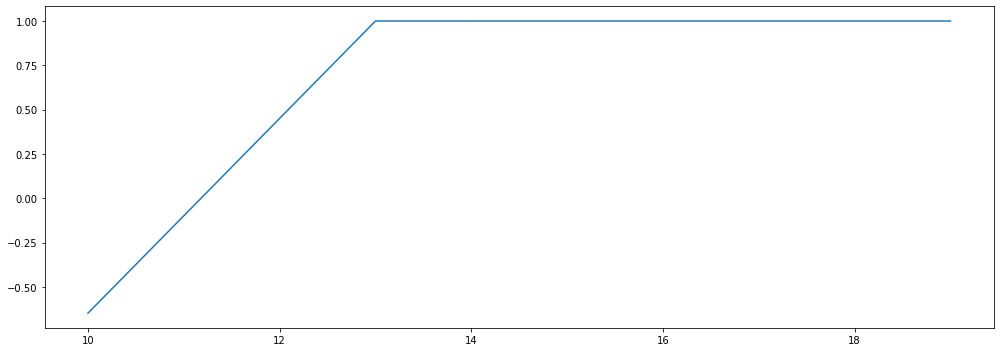

In [12]:
tlist, plist = [], range(10, 20, 3)
for npt in plist:
    s, t = solve_basic_waittime_problem(npt, capacities)
    tlist.append(t)
er.plot_scalability_evalulation(plist, np.log10(tlist), figsize=figsize)

_Sum-based_ objectives are much harder in CP and _max-based_ objectives

- A bound on a max-based objective immediately propagates to all its terms
- ...For sum-based objectives, this is not the case

# Goal Programming

## Goal Programming

**Any practical application of our method faces _two big issues_**

First, we have limited _scalability_

* The problem is computationally challenging
* Note that we may still be getting good solutions quite early
* ...But we need to compare multiple solution approaches to know that

Second, we need to handle _patient priorities_

* We need to make sure that (e.g.) red-coded patients are handled first
* ...Then yellow, green, and finally white patients

**We can actually address both with a single technique!**

(At least to some degree)

## Goal Programming

**Goal Programming is a strategy for handling _lexicographic costs_**

* Let's consider a problem with _multiple cost functions_ $f_0(x), f_1(x), \ldots$
* Let $f_i$ be _strictly more important_ than $f_j$ iff $i < j$

**Then _Goal Programming_ refers to this simple algorithm:**

* Optimize $f_0(x)$ to obtain its optimal value $z^*_0$
* Post a new constraint in the model in the form $f_0(x) \leq z^*_0$
* Move to the next cost function and repeat

**The approach is very simple, but it works well in practice**

A typical example: the Capacitated Vehicle Routing Problem

* $f_0(x) = $ number of vehicles, $f_1(x) = $ length of the routes
* Thanks to GP, we get an upped bound on each cost at each step
* ...Which may provide a computational advantage

## Implementing Goal Programming

**As a first step, we need to handle _upper bounds_ on the waiting times**

```python
def solve_bounded_waittime_problem(levels, codes_by_idx, codes, capacities,
        ub_by_code={}, tlim=None):
    mdl = cp_model.CpModel()    
    eoh = get_horizon(levels)
    rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
    tasks, last = add_all_vars(mdl, levels, rl, dl)
    add_all_precedences(mdl, levels, tasks)
    add_cumulatives(mdl, tasks, {'visit': 3, 'ultrasound': 2, 'RX': 2})
    add_all_no_overlap(mdl, levels, tasks)
    obj_by_code = add_waittime_variables(mdl, levels, codes_by_idx, tasks, eoh)
    
    for code in ub_by_code: # <-- Enforce upper bounds
        mdl.Add(obj_by_code[code] <= ub_by_code[code])

    mdl.Minimize(obj_by_code[codes[-1]]) # <-- Focus by default on the last code
    slv = cp_model.CpSolver()
    if tlim is not None: slv.parameters.max_time_in_seconds = tlim
    status = slv.Solve(mdl)    
    return status, slv, tasks
```

## Implementing Goal Programming

**Then we need to code the approach in a function**

```python
def goal_programming(levels, codes_by_idx, codes, capacities, tlim=None, verbose=1):
    wt_by_code, ttime = {}, 0
    for i, code in enumerate(codes):
        l_tlim = None if tlim is None else (tlim-ttime) / (len(codes)-i)
        status, slv, tasks = solve_bounded_waittime_problem(levels, codes_by_idx,
                          codes[:i+1], capacities, ub_by_code=wt_by_code, tlim=l_tlim)
        ttime += slv.UserTime()
        if verbose:
            print_outcome(slv, levels, tasks, codes_by_idx, status, (i == len(codes)-1))
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            wt_by_code[code] = int(slv.ObjectiveValue())
            starts = {tidx:slv.Value(tasks[tidx].start) for tidx in tasks}
        else:
            wt_by_code, starts = None, None
            break
    if wt_by_code is not None:
        wt_by_code['all'] = sum(wt_by_code[code] for code in codes)
    return ttime, wt_by_code, starts
```

## Implementing Goal Programming

**Finally, we can test the approach**

We choose a _priority for our codes_, then we call the `goal_programming` function

In [8]:
codes = ['red', 'yellow', 'green', 'white']
npatients = 10
levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])
_, _, _ = er.goal_programming(levels, codes_by_idx, codes, capacities, tlim=10)

Solver status: optimal, time(CPU sec): 0.01, objective: 0.0
Solver status: optimal, time(CPU sec): 0.01, objective: 0.0
Solver status: optimal, time(CPU sec): 0.02, objective: 9.0
Solver status: optimal, time(CPU sec): 0.04, objective: 3.0

0(green): visit(0-1), RX(1-3), visit(3-4)
9(green): visit(0-1)
12(red): visit(0-1), RX(3-5), visit(5-6)
6(green): visit(1-2), ultrasound(2-4), RX(4-6), lab(6-10), CT scan(10-14), visit(14-15), CT scan(15-19), visit(19-20)
7(green): visit(1-2)
8(green): visit(1-2), RX(2-4), prescription(4-8), visit(8-9)
1(green): visit(2-3), lab(3-7), visit(7-8)
10(green): visit(2-3), lab(3-7), CT scan(7-11), visit(11-12)
11(green): visit(2-3), ultrasound(3-5), lab(5-9), prescription(9-13), visit(13-14)
2(white): visit(3-4), otolaryngological visit(4-8), visit(8-9)


* The priority is given by the code order in the list

## Evaluation

**We can now evaluate the scalability of the approach**

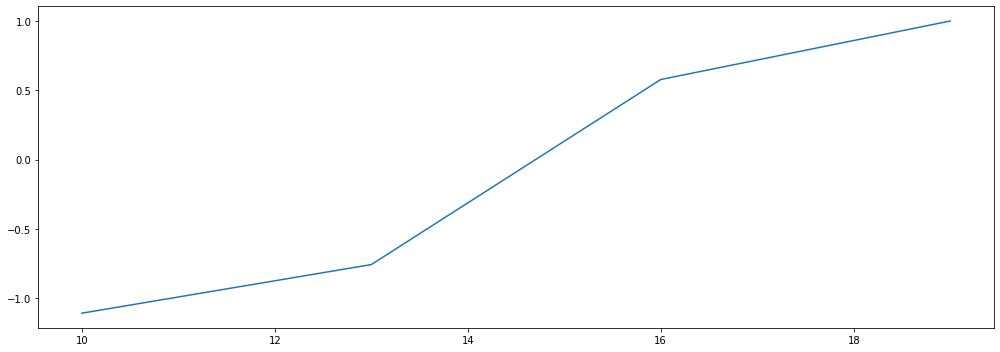

In [13]:
tlist, olist, plist = [], [], range(10, 20, 3)
for npt in plist:
    levels, codes_by_idx = er.build_levels(fdata.iloc[:npt])
    t, o, _ = er.goal_programming(levels, codes_by_idx, codes, capacities, tlim=10, verbose=0)
    tlist.append(t)
    olist.append(o['all'])
er.plot_scalability_evalulation(plist, np.log10(tlist), figsize=figsize)

* We will use these value as a reference for some comparisons later

## Warm Starting

**A drawback of GP is that search restarts from scratch at each iteration**

* This can be mitigated by _warm starting_ the solver
* In Google ortools, this is done via so-called "hints"

```python
def goal_programming(levels, codes_by_idx, codes, capacities,
        tlim=None, verbose=1, hints=None):
        ...
        status, slv, tasks = solve_bounded_waittime_problem(levels, codes_by_idx,
                codes[:i+1], capacities, ub_by_code=wt_by_code,
                tlim=l_tlim, hints=hints) # <-- here we pass hints
        ...
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            ...
            starts = {tidx:slv.Value(tasks[tidx].start) for tidx in tasks}
            hints = starts # <-- hints are the start in the last solution
        ...
```

## Warm Starting

**And finally we need to take into account the hints in the model:**

```python
def solve_bounded_waittime_problem(levels, codes_by_idx, codes, capacities,
        ub_by_code={}, tlim=None, hints=None):
    ...
    # Add hints
    if hints is not None:
        for (idx, k, i), stval in hints.items():
            mdl.AddHint(tasks[idx,k,i].start, stval)
    ...
```

* The solver will _try to assign_ to each value the corresponding hint
* In case this proves impossible, it will search as usual
* If properly done, this guarantees that we start from a known feasible solution

This is usually referred to as _warm starting_ in the optimization field

## Warm Starting

**Let's test this updated implementation**

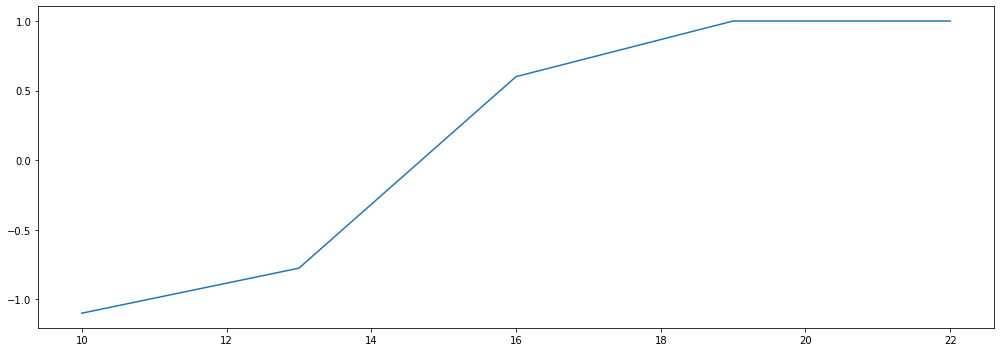

In [14]:
tlist2, plist2 = [], range(10, 23, 3)
for npt in plist2:
    levels, codes_by_idx = er.build_levels(fdata.iloc[:npt])
    t, _, _ = er.goal_programming(levels, codes_by_idx, codes, capacities, tlim=10, verbose=0)
    tlist2.append(t)
er.plot_scalability_evalulation(plist2, np.log10(tlist2), figsize=figsize)

* It does not make much of a difference at this point, but it will matter later

# Large Neighborhood Search

## Large Neighborhood Search

**Exact optimization approaches (e.g. classical CP/SMT)...**

* ...Enable _convenient modeling_ and are very effective on small problems
* ...But have trouble dealing with large-scale optimization problems

**Heuristic approaches (e.g. local search)...**

* ...Can deal with large scale problems
* ...But have trouble escaping local minima

**The two approaches can be combined to obtain _Large Neighborhood Search_**

* We operate by trying to improve an _incumbent solution_
* Improving solutions are searched in a _large neighborhood_
* Each neighborhood is explored via a complete search on a _restricted problem_
* ...Typically: we fix all variables, except a small subset (_relaxed variables_)

## Large Neighborhood Search

**Here's a visual scheme of how the approach works**

<center><img src="assets/lns.png" width=700px/></center>

**LNS _combines the strengths_ of its component approaches**

* It can efficiently handle large-scale problems (like local search)
* It can escape local minima thanks to the use of large neighborhoods
* It retains the modeling flexibility of CP, SMT, MILP, etc.

**Choosing which variables to relax at each iteration...**

* ...Can be a major design decision, and can be done using domain knowledge
* ...But actually even a simple _random selection_ often works very well


## Variable Fixing in Scheduling

**LNS can be very effective on _scheduling problems_...**

* ...But it is not straightforward to implement
* ...Since the classical "variable" fixing approach provides _too little flexibility_

**Consider the following schedule for a resouce with capacity 2:**

<center><img src="assets/pos_issue.png" width=700px/></center>

* Say the we choose to relax the green tasks, and keep the yellow ones fixed
* ...Then we still cannot make any improvement!

**We need to retain some ability to _shift tasks in time_**

* But we still need to keep them somewhat "fixed"
* ...Or there is no point in defining a neighborhood


## Partial Order Schedule

**The solution is converting a fixed-start schedule into a _Partial Order Schedule_**

A Partial Order Schedule is an _augmented task graph_

<center><img src="assets/pos_example.png" width=700px/></center>

* The graph contains all the original precedence relations (in this case none)
* ...Plus additional precedences, introduced to _prevent resource conflicts_

**In the figure:**

* As long as the black arcs (precedences) are respected
* ...Tasks can be moved _without any resource conflict_

## Partial Order Scheduling

**A POS can be obtained by solving a _minimum flow problem_**

<center><img src="assets/flow1.png" width=700px/></center>

* First, we introduce a fake "source" and "sink" task
* Then, we build an arc for each pair of tasks such that $e_i \leq s_j$
  - The source can be connected only to the first tasks
  - ...And the sink has an incoming arc for each last task
* Then we say each task "requires" flow equal to its resource demand
  - In this example, all requirements are 1

## Partial Order Scheduling

**A POS can be obtained by solving a minimum flow problem**

<center><img src="assets/flow2.png" width=700px/></center>

* Finally, we route the minimum amount of flow that satisfies the requirements
  - ...For example using some variant of the Ford-Fulkerson's method
  - We will not look into details into this
* The arcs with non-zero flow become part of the POS
  - In the figure, these are the arcs in black
  - You can check that the flow is actually minimum

## POS Conversion - Implementation

**Since we have only unary demands, our implementation can be simpler**

First, let's prepare a function to _collect and sort the tasks for each resource_:

```python
def sol_to_pos(levels, starts, capacities):
    aplus, aminus = {}, {}
    stasks = {r:[] for r in capacities}
    for idx, k, i in starts:
        ttype = levels[idx][k][i]
        if ttype in capacities:
            stasks[ttype].append((idx, k, i))
            aplus[idx, k, i], aminus[idx, k, i] = [], []
    for res in capacities:
        stasks[res] = sorted(stasks[res], key=lambda t: starts[t]) # <-- sort by start
    for res, cap in capacities.items():
        for _ in range(cap):
            stasks[res] = unit_flow(levels, stasks[res], starts, aplus, aminus)
    return aplus, aminus
```

## POS Conversion - Implementation

**We store the POS as a collection of outgoing and ingoing arcs**

This is called a _forward and backward star_ representation:

```python
def sol_to_pos(levels, starts, capacities):
    aplus, aminus = {}, {}
    ...
    for idx, k, i in starts:
        ...
        if ttype in capacities:
            ...
            aplus[idx, k, i], aminus[idx, k, i] = [], []
    ...
    return aplus, aminus
```

* The chosen representation allows for efficient graph traversal
* It also makes it easy to detect arcs implied via the transitive property

## POS Conversion - Implementation

**Then, we collect the tasks for each resource:**

```python
def sol_to_pos(levels, starts, capacities):
    ...
    stasks = {r:[] for r in capacities}
    for idx, k, i in starts:
        ttype = levels[idx][k][i]
        if ttype in capacities:
            stasks[ttype].append((idx, k, i))
            ...
    for res in capacities:
        stasks[res] = sorted(stasks[res], key=lambda t: starts[t])
    ...
```

* We sort each collection by increasing start time

## POS Conversion - Implementation

**Finally, we route single units of flows**

```python
def sol_to_pos(levels, starts, capacities):
    ...
    for res, cap in capacities.items():
        for _ in range(cap):
            stasks[res] = unit_flow(levels, stasks[res], starts, aplus, aminus)
    return aplus, aminus
```

* Each unit corresponds to one unit of resource capacity
* The flow represents how the resource is "passed" form one task to the next
* We do not build explicitly the possible arcs: they are implied by the start times

## POS Conversion - Implementation

**Here is the algorithm for routing each flow unit**

```python
def unit_flow(levels, stasks, starts, aplus, aminus):
    nonprocessed = []
    src, dur = None, 0
    for dst in stasks:
        if src is not None and starts[src] + dur <= starts[dst]:
            aplus[src].append(dst) # Build an arc (forward star)
            aminus[dst].append(src) # Build an arc (backward star)
            src = None # Reset the source
        if src is None:
            src = dst # Set a new source
            dur = get_dur(levels[src[0]][src[1]][src[2]])
        else:
            nonprocessed.append(dst) # Store as non-processed
    return nonprocessed

```

## POS Conversion - Implementation

**Let's test the function**

In [15]:
codes = ['red', 'yellow', 'green', 'white']
npatients = 3
levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])
_, _, starts = er.goal_programming(levels, codes_by_idx, codes, capacities, tlim=10)
aplus, aminus = er.sol_to_pos(levels, starts, capacities)
aplus

Solver status: optimal, time(CPU sec): 0.00, objective: 0.0
Solver status: optimal, time(CPU sec): 0.00, objective: 0.0
Solver status: optimal, time(CPU sec): 0.00, objective: 0.0
Solver status: optimal, time(CPU sec): 0.01, objective: 0.0

0(green): visit(0-1), RX(1-3), visit(3-4)
1(green): visit(0-1), lab(1-5), visit(5-6)
2(white): visit(0-1), otolaryngological visit(1-5), visit(5-6)


{(0, 0, 0): [(0, 2, 0)],
 (0, 1, 0): [],
 (0, 2, 0): [(1, 2, 0)],
 (1, 0, 0): [(2, 2, 0)],
 (1, 2, 0): [],
 (2, 0, 0): [],
 (2, 2, 0): []}

## POS Relaxation

**A POS corresponds to a set of feasible schedules**

* Tasks can be freely shifted, and no resource constraints is be violated
* There are _no longer ordering decisions_ to be made
* Typically, choosing one of the possible schedules becomes a poly-time problem

However, this means that we cannot really make significant changes

**For using a POS in LNS, we need to _relax_ it**

Typically:

* We choose a set of tasks to relax
* ...And we disconnect them from the precedence network
  * First, we connect all task predecessors to the task successors
  * Then, we remove all the additional POS arcs linked to the relaxed tasks

## POS Relaxation - Implementation

**Here's an implemented algorithm for removing/relaxing POS tasks**

```python
def remove_task_from_pos(aplus, aminus, task_key):
    # Transfer transitive arcs
    for src in aminus[task_key]:
        for dst in aplus[task_key]:
            aminus[dst].append(src)
            aplus[src].append(dst)
    # Remove ingoing arcs
    for src in aminus[task_key]:
        aplus[src].remove(task_key)
    # Remove outgoing arcs
    for dst in aplus[task_key]:
        aminus[dst].remove(task_key)
    # Remove the node from the arc
    del aplus[task_key]
    del aminus[task_key]
```

## POS Relaxation - Implementation

**In our LNS approach we will relax all tasks related to selected patients**

```python
def remove_patient_from_pos(aplus, aminus, target_idx):
    aplus_res = copy.deepcopy(aplus)
    aminus_res = copy.deepcopy(aminus)
    for idx, k, i in aplus:
        if idx == target_idx:
            remove_task_from_pos(aplus_res, aminus_res, (idx, k, i))
    return aplus_res, aminus_res
```

In [16]:
aplus2, aminus2 = er.remove_patient_from_pos(aplus, aminus, 2)
aplus2

{(0, 0, 0): [(0, 2, 0)],
 (0, 1, 0): [],
 (0, 2, 0): [(1, 2, 0)],
 (1, 0, 0): [],
 (1, 2, 0): []}

## Restricted Problem

**We now need to take int account the additional precedences in the model**

```python
def solve_bounded_waittime_problem(levels, codes_by_idx, codes, capacities,
        ub_by_code={}, tlim=None, hints=None, aplus=None):
    ...
    # Add extra precedences
    if aplus is not None:
        for (idx, k, i), out_arcs in aplus.items():
            for idx2, k2, i2 in out_arcs:
                mdl.Add(tasks[idx,k,i].end <= tasks[idx2,k2,i2].start)
    ...
```

Even if we still need to assing _all the start times_...

* Precedence constraints are efficient to propagate
* They are effective at narrowing the variable domains
* ...And in this case they prevent many resource conflicts

**If many POS constraints are added, the problem is much easier to solve**

## LNS - Initial Solution

**We are ready to define our LNS approach**

First, we need an initial solution:

In [17]:
init_time = 5 # Time limit for the initial solution
codes = ['red', 'yellow', 'green', 'white']
npatients = 100

levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])

ttime, wt_by_code, starts = er.goal_programming(levels, codes_by_idx, codes, capacities=capacities,
                           tlim=init_time, verbose=0)
print(f'Initial solution in {ttime:.2f} sec, {wt_by_code}')

Initial solution in 5.01 sec, {'red': 5, 'yellow': 577, 'green': 1209, 'white': 10, 'all': 1801}


* We can obtain this one as usual
* It's better if it's of decent quality
* ...But we don't want to spend more than a few seconds on this

## LNS - Baseline

**As a baseline, let's see the solution quality we can obtain in 30 seconds**

In [22]:
init_time = 30 # Time limit for the initial solution
codes = ['red', 'yellow', 'green', 'white']
npatients = 100

levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])

ttime, wt_by_code, starts = er.goal_programming(levels, codes_by_idx, codes, capacities=capacities,
                           tlim=init_time, verbose=0)
print(f'Initial solution in {ttime:.2f} sec, {wt_by_code}')

Initial solution in 30.02 sec, {'red': 5, 'yellow': 307, 'green': 1343, 'white': 22, 'all': 1677}


## LNS - Upper bounds

**In LNS we will repeatedly be seeking for an _improving_ solution**

...So we need to modify our G.P. loop to take _upper bounds_ into account:

```python
def goal_programming(levels, codes_by_idx, codes, capacities,
        tlim=None, verbose=1, hints=None, ub_by_code=None):
    # Handle the upper bounds
    if ub_by_code is None:
        wt_by_code = {}
    else:
        wt_by_code = copy.deepcopy(ub_by_code)
    ...
    return ttime, wt_by_code, starts

```

* The bounds are then passed to the function that builds and solves the model
* ...Which was already designed to deal with the bounds from Goal Programming

## LNS - Main Loop

**Here is the main structure of our LNS implementation:**

```python
def scheduling_lns(levels, codes_by_idx, codes, capacities,
        tlim, init_time, it_time, nb_size, verbose=1):
    ... # Build initial solution
    while tlim - ttime > 0:
        aplus, aminus = sol_to_pos(levels, starts, capacities) # Obtain a POS
        relaxed = np.random.choice(patients, nb_size, replace=False) # Relax patients
        for idx in relaxed: aplus, aminus = remove_patient_from_pos(aplus, aminus, idx)
        ub_by_code = copy.deepcopy(wt_by_code) # Require an improvement
        ub_by_code['all'] -= 1
        ... # Re-solve
        ttime += max(itime, 0.1) # Update the time limit
        ... # Update the best solution
```

The full implementation can be found in our support module

## Evaluation

**Time to test! Waiting times are sorted by code, the last is the total**

In [23]:
# Configuration
tlim = 30
init_time, it_time, nb_size = 3, 1, 4
codes = ['red', 'yellow', 'green', 'white']
npatients = 100
levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])

er.scheduling_lns(levels, codes_by_idx, codes, capacities, tlim, init_time, it_time, nb_size);

Initial solution in 2.90 sec, {'red': 5, 'yellow': 649, 'green': 1386, 'white': 10, 'all': 2050}
Total time: 3.67, neighborhood explored in 0.77 sec, waiting times 5,630,1364,10,2009
Total time: 4.45, neighborhood explored in 0.78 sec, waiting times 5,625,1364,10,2004
Total time: 5.20, neighborhood explored in 0.75 sec, waiting times 5,622,1364,10,2001
Total time: 5.98, neighborhood explored in 0.78 sec, waiting times 5,613,1361,10,1989
Total time: 6.63, neighborhood explored in 0.65 sec, waiting times 5,605,1359,10,1979
Total time: 7.28, neighborhood explored in 0.66 sec, waiting times 5,590,1338,10,1943
Total time: 8.04, neighborhood explored in 0.76 sec, waiting times 5,583,1333,10,1931
Total time: 8.82, neighborhood explored in 0.77 sec, waiting times 5,567,1330,10,1912
Total time: 9.60, neighborhood explored in 0.78 sec, waiting times 5,557,1330,10,1902
Total time: 10.25, neighborhood explored in 0.65 sec, waiting times 5,549,1328,10,1892
Total time: 11.03, neighborhood explored i

## Considerations

**LNS is the industrial optimizer's secret weapon**

* It's flexible, robust, scalable, and not too difficult to implement
  - Except for  scheduling problems, but you've now seen how to do it ;-)
* It's usually possible to do better than LNS, but it's also considerably harder

**Goal programming is not only about lexicographic costs**

* It's about simplifying a problem via constraints
* E.g. constraints may actually help in CP
* Sometimes special optimization are possible:
  - Include only some of the variables (e.g. red-codes only)
  - Simplified problem formulation (e.g. fixed number of vehicles)

**Do not underestimate warm starts**

* Without our little trick at the beginning
* ...The search for an initial solution with 100 patients would fail!